# Q-Variance

This notebook computes the **Q-Variance equation** from any OHLCV CSV file of price data,
for horizons **T = 1 to 26 weeks**, and produces the red parabola:

> **σ² = σ₀² + (z − zoff)² / 2**

Works whether `Date` is a column or the index — just drop in the path to your CSV file. Note that this code is for a single asset only, best results are obtained by averaging over a number of assets. Also, here we have used the example of the S&P 500 index, which represents an average over stock prices rather than a stock price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('default')

## 1. Load Data 

Change CSV_FILE to your file path.

In [2]:
# CHANGE THIS TO YOUR FILE
CSV_FILE = "indexSP1928.csv"   # or "SPY.csv", "BTC-USD.csv", etc.

def load_prices(filepath):
    df = pd.read_csv(filepath)
    
    # Case 1: Date is a column
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
    
    # Case 2: First column is empty and index is date
    elif df.columns[0] == '' or 'Unnamed: 0' in df.columns[0]:
        df = df.rename(columns={df.columns[0]: 'Date'})
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
    
    # Prefer Adj Close → Close → last column
    price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close' if 'Close' in df.columns else df.columns[-1]
    prices = df[price_col].dropna()
    prices = prices.sort_index()
    
    print(f"Loaded {len(prices):,} daily prices from {prices.index[0].date()} to {prices.index[-1].date()}")
    print(f"Using price column: '{price_col}'")
    return prices

prices = load_prices(CSV_FILE)
log_returns = np.log(prices / prices.shift(1)).dropna()

Loaded 24,376 daily prices from 1927-12-30 to 2025-01-15
Using price column: 'Close'


## 2. Compute Variance vs Scaled Return z for T = 1–26 weeks

In [3]:
rows = []
scale = np.sqrt(252)

print("Computing Q-Variance curve for T = 1 to 26 weeks...")
HORIZONS = 5*(np.arange(26)+1)   # does 1 to 26 weeks, can also do [5, 10, 20, 40, 80, 160]
for T in HORIZONS:
    i = 0
    while i + T <= len(log_returns):
        window = log_returns[i:i+T]     # T points
        if len(window) < T * 0.8:
            break

        x = window.sum()   # total price change over the period
        sigma = np.std(window, ddof=0) * scale      # ddof=0 means divisor is N, not N-1
        varcur = sigma**2
        z_raw = x / np.sqrt(T / 252.0)

        # REJECT BAD WINDOWS
        if not (np.isfinite(sigma) and sigma > 0 and np.isfinite(z_raw)):
            i += T
            continue

        rows.append({          # append row of data for this period
            "date": prices.index[i + T - 1].date(),
            "T": T,
            "z_raw": float(z_raw),
            "var": float(varcur)
        })
        i += T

df = pd.DataFrame(rows)

# CLEAN BEFORE DE-MEANING 
df = df[np.isfinite(df['z_raw']) & np.isfinite(df['var']) & (df['var'] > 0)]

# NOW de-mean safely, this step groups by T, and subtracts the group mean 
df["z"] = df.groupby(["T"])["z_raw"].transform(lambda g: g - g.mean())

df = df.drop(columns="z_raw")
df = df.dropna().reset_index(drop=True)  # Final clean, can save as e.g. parquet file

print(f"Generated {len(df["z"]):,} data points")

Computing Q-Variance curve for T = 1 to 26 weeks...
Generated 18,780 data points


## 3. Fit the Q-Variance Parabola

In [4]:
def q_variance_model(z, sigma0, zoff):
    return sigma0**2 + (z - zoff)**2 / 2

# Binning
zmax = 0.6
Z_BINS = np.linspace(-zmax, zmax, 61)
bin_means, bin_edges, _ = binned_statistic(df["z"], df["var"], statistic='mean', bins=Z_BINS)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
valid = ~np.isnan(bin_means)

# Fit
popt, pcov = curve_fit(q_variance_model, bin_centers[valid], bin_means[valid],
                       p0=[0.25, 0.02], bounds=([0.01, -0.1], [0.5, 0.1]))
sigma0_fit, zoff_fit = popt
perr = np.sqrt(np.diag(pcov))

# R²
predicted = q_variance_model(bin_centers[valid], *popt)
ss_res = np.sum((bin_means[valid] - predicted)**2)
ss_tot = np.sum((bin_means[valid] - np.mean(bin_means[valid]))**2)
r_squared = 1 - ss_res / ss_tot

print(f"\nQ-Variance Fit Results:")
print(f"  σ₀   = {sigma0_fit:.4f} ± {perr[0]:.4f}")
print(f"  zoff = {zoff_fit:.4f} ± {perr[1]:.4f}")
print(f"  R²   = {r_squared:.4f}")


Q-Variance Fit Results:
  σ₀   = 0.1375 ± 0.0108
  zoff = 0.0149 ± 0.0085
  R²   = 0.8572


## 4. The Q-Variance Plot

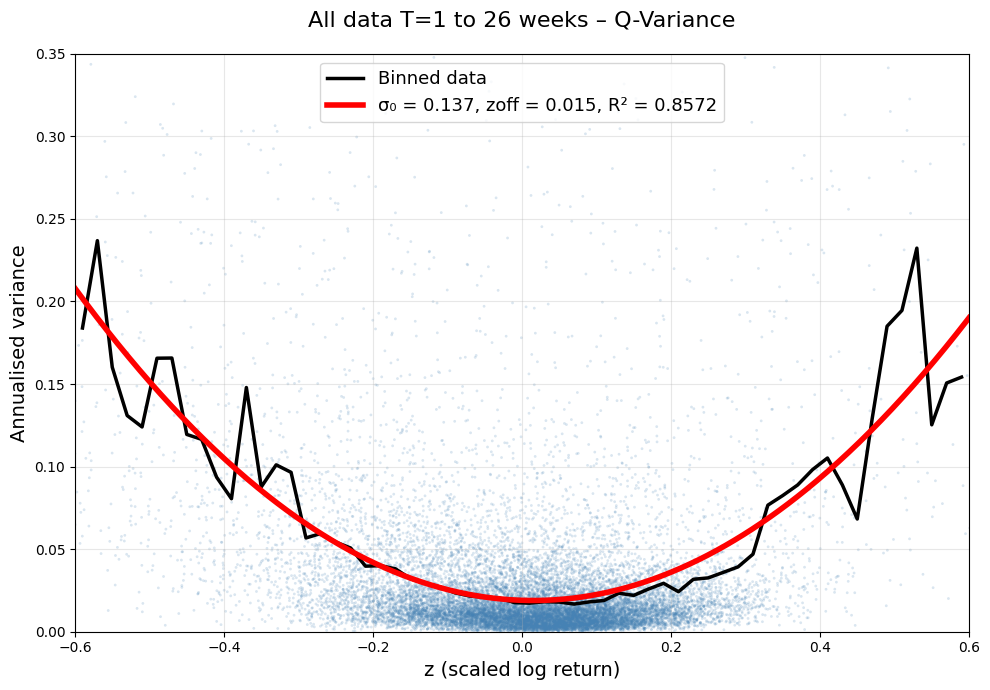

In [5]:
plt.figure(figsize=(10, 7))

# Scatter plot
plt.scatter(df["z"], df["var"], c='steelblue', alpha=0.2, s=4, edgecolor='none')

# Binned data
plt.plot(bin_centers[valid], bin_means[valid], 'k-', lw=2.5, label='Binned data')

# Q-Variance fit
z_fine = np.linspace(-zmax, zmax, 500)
plt.plot(z_fine, q_variance_model(z_fine, *popt),
         color='red', lw=4,
         label=f'σ₀ = {sigma0_fit:.3f}, zoff = {zoff_fit:.3f}, R² = {r_squared:.4f}')

plt.xlabel('z (scaled log return)', fontsize=14)
plt.ylabel('Annualised variance', fontsize=14)
plt.title('All data T=1 to 26 weeks – Q-Variance', fontsize=16, pad=20)
plt.xlim(-zmax, zmax)
plt.ylim(0, 0.35)
plt.grid(alpha=0.3)
plt.legend(fontsize=13, loc='upper center')
plt.tight_layout()

# Save for publication
# plt.savefig("Q_Variance_Parabola.png", dpi=300, bbox_inches='tight')
# plt.savefig("Q_Variance_Parabola.pdf", bbox_inches='tight')
plt.show()

## The Results

Plot shows variance as a function of z (black) and the fitted q-variance curve (red) for this asset. To reduce noise and obtain a better fit, use a long time series or combine different stocks.